In [1]:
pip install --upgrade tensorflow keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [4]:
# Charger le dataset
df = pd.read_csv('/content/drive/MyDrive/Copy of concatenated_df.csv')  # Adapter au format du dataset

In [5]:
df.columns

Index(['product_title', 'product_category', 'star_rating', 'helpful_votes',
       'review_body', 'normalized_review_body', 'review_body_compound_score',
       'review_body_sentiment_label'],
      dtype='object')

In [6]:
import re

def remove_emoji(string):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string)


def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#","", temp)
    temp = remove_emoji(temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)

    return temp
df['review_body'] = df['review_body'].map(lambda x : clean_tweet(x))

In [7]:

df = df[['review_body', 'review_body_sentiment_label']]  # Adapter aux noms des colonnes

In [8]:
df

,review_body,review_body_sentiment_label
0,not as bright as i thought it would be,negative
1,very large to 173cm 53kgs on size s,neutral
2,i would not recommend this to anyone needing ...,negative
3,cool looking watch sporty and durable but th...,negative
4,my husbands second pair,neutral
...,...,...
361146,beautiful lights look great on my black 95 ta...,positive
361147,i actually expected that these googles will ha...,negative
361148,this watch is alot of fun you dont see chip a...,positive
361149,gets the job done 12 to know how your solar ...,positive


<ipython-input-9-0001300011a6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='muted')


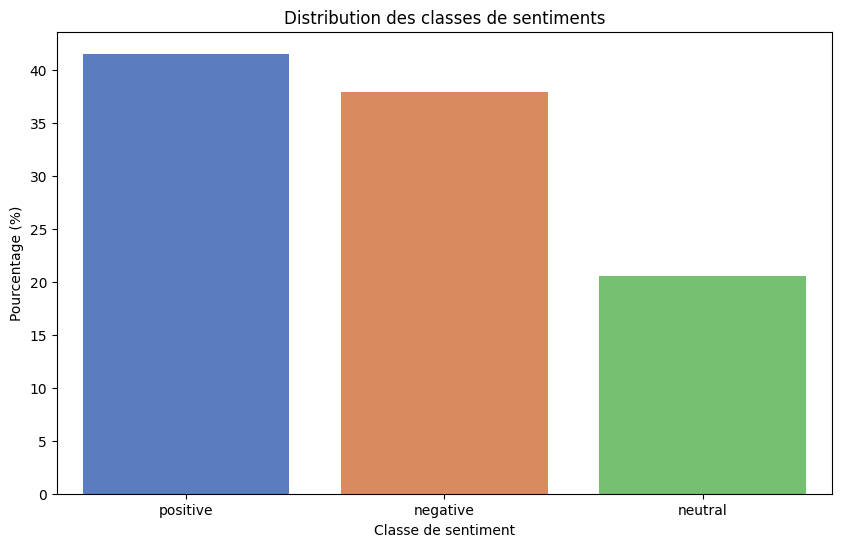

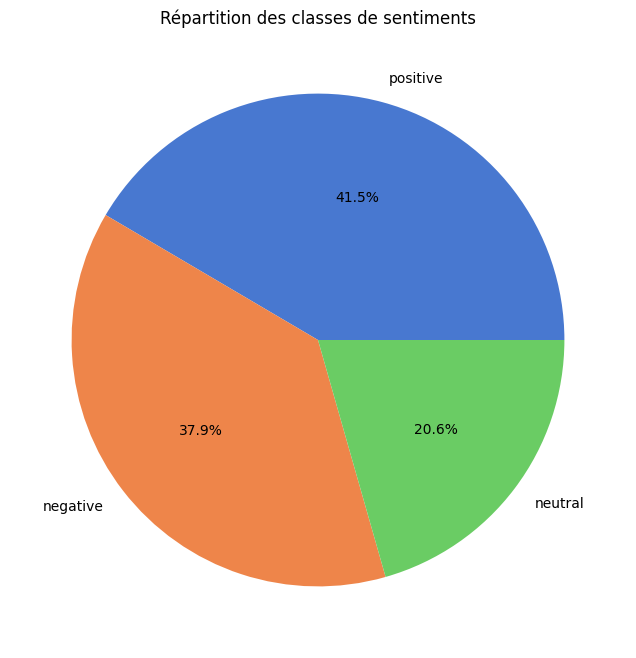

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des classes dans le dataset
class_distribution = df['review_body_sentiment_label'].value_counts(normalize=True) * 100

# Afficher la distribution sous forme de barres
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='muted')
plt.title('Distribution des classes de sentiments')
plt.xlabel('Classe de sentiment')
plt.ylabel('Pourcentage (%)')
plt.show()

# Afficher la distribution sous forme de camembert
plt.figure(figsize=(8, 8))
plt.pie(class_distribution.values, labels=class_distribution.index, autopct='%1.1f%%', colors=sns.color_palette('muted'))
plt.title('Répartition des classes de sentiments')
plt.show()

In [ ]:
# Tracer les courbes d'apprentissage
def plot_history(hist):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy', color='blue', linestyle='--')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy', color='red')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(loc='best')
    plt.title('Train vs Validation Accuracy', fontsize=15)

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss', color='blue', linestyle='--')
    plt.plot(hist.history['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend(loc='best')
    plt.title('Train vs Validation Loss', fontsize=15)

    plt.tight_layout()
    plt.show()


In [9]:
df.review_body_sentiment_label.unique()

array(['negative', 'neutral', 'positive'], dtype=object)

In [10]:
# Encoder les étiquettes
label_encoder = LabelEncoder()
df['review_body_sentiment_label'] = label_encoder.fit_transform(df['review_body_sentiment_label'])

<ipython-input-10-da33813b56ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['review_body_sentiment_label'] = label_encoder.fit_transform(df['review_body_sentiment_label'])


In [11]:
# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(df['review_body'], df['review_body_sentiment_label'], test_size=0.2, random_state=42)

In [12]:
# Paramètres du Tokenizer
MAX_NUM_WORDS = 20000  # Nombre maximal de mots à garder dans le vocabulaire
MAX_SEQUENCE_LENGTH = 100  # Longueur maximale des séquences
EMBEDDING_DIM = 100  # Dimension des vecteurs d'embedding

# Tokenisation des textes
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [13]:
# Convertir les textes en séquences et appliquer le padding
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)


In [14]:
# Construire le modèle LSTM
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Modifier en fonction du nombre de classes

# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Configurer un early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history = model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.8215 - loss: 0.4665 - val_accuracy: 0.9100 - val_loss: 0.2652
Epoch 2/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 76s 11ms/step - accuracy: 0.9076 - loss: 0.2708 - val_accuracy: 0.9158 - val_loss: 0.2483
Epoch 3/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - accuracy: 0.9249 - loss: 0.2240 - val_accuracy: 0.9203 - val_loss: 0.2370
Epoch 4/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 148s 12ms/step - accuracy: 0.9332 - loss: 0.1948 - val_accuracy: 0.9236 - val_loss: 0.2362
Epoch 5/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 126s 10ms/step - accuracy: 0.9406 - loss: 0.1722 - val_accuracy: 0.9223 - val_loss: 0.2433


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, matthews_corrcoef
import numpy as np

# Évaluer le modèle
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculer et afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, y_pred))

# Calculer et afficher l'accuracy (précision globale)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculer et afficher la précision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculer et afficher le ROC-AUC
# Pour le ROC-AUC, nous devons encoder les labels en format one-hot
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc}")

# Calculer et afficher le MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc}")


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
              precision    recall  f1-score   support

    negative       0.89      0.95      0.92     27642
     neutral       0.98      0.83      0.90     14732
    positive       0.93      0.94      0.94     29857

    accuracy                           0.92     72231
   macro avg       0.93      0.91      0.92     72231
weighted avg       0.92      0.92      0.92     72231

[[26304   140  1198]
 [ 1737 12166   829]
 [ 1605   139 28113]]
Accuracy: 0.9218064266035358
Precision: 0.9244877195078953
ROC-AUC: 0.9822887686873547
MCC: 0.8782045990188492


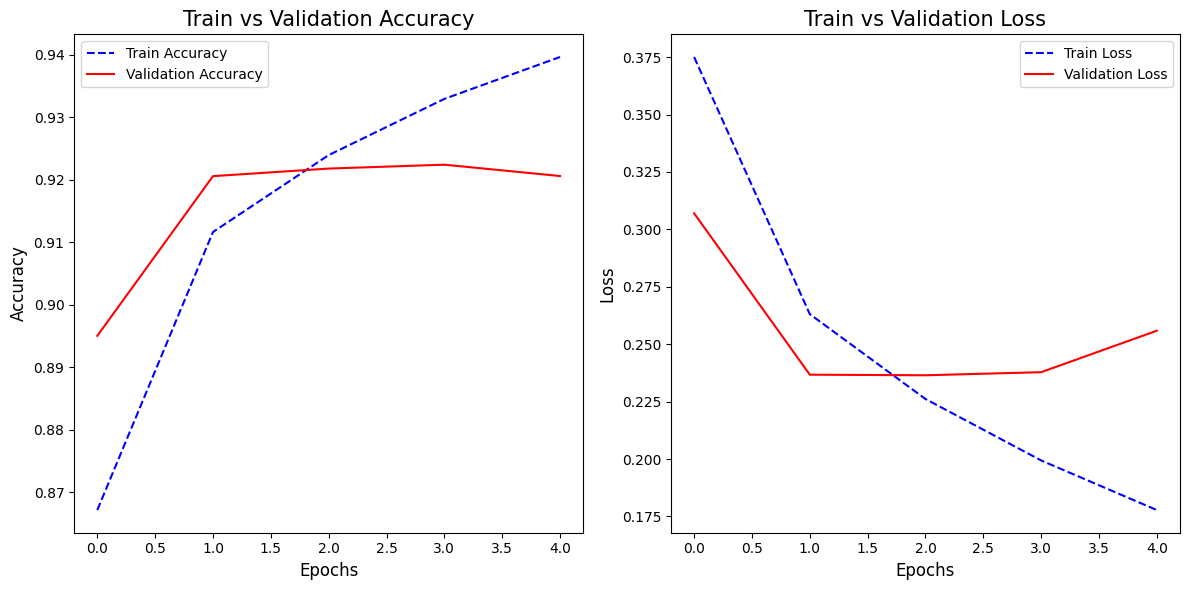

In [ ]:
plot_history(history)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, GRU, GlobalMaxPooling1D, BatchNormalization, Dense
# Construire le modèle GRU
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(GRU(128, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Modifier en fonction du nombre de classes


# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Configurer un early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history1 = model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_2               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 75s 10ms/step - accuracy: 0.8169 - loss: 0.4765 - val_accuracy: 0.9128 - val_loss: 0.2577
Epoch 2/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 74s 10ms/step - accuracy: 0.9128 - loss: 0.2622 - val_accuracy: 0.9199 - val_loss: 0.2405
Epoch 3/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 80s 10ms/step - accuracy: 0.9260 - loss: 0.2209 - val_accuracy: 0.9221 - val_loss: 0.2333
Epoch 4/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - accuracy: 0.9351 - loss: 0.1915 - val_accuracy: 0.9241 - val_loss: 0.2387
Epoch 5/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - accuracy: 0.9416 - loss: 0.1697 - val_accuracy: 0.9223 - val_loss: 0.2373


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, matthews_corrcoef
import numpy as np

# Évaluer le modèle
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculer et afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, y_pred))

# Calculer et afficher l'accuracy (précision globale)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculer et afficher la précision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculer et afficher le ROC-AUC
# Pour le ROC-AUC, nous devons encoder les labels en format one-hot
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc}")

# Calculer et afficher le MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc}")


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
              precision    recall  f1-score   support

    negative       0.88      0.96      0.92     27642
     neutral       0.97      0.83      0.89     14732
    positive       0.94      0.94      0.94     29857

    accuracy                           0.92     72231
   macro avg       0.93      0.91      0.92     72231
weighted avg       0.92      0.92      0.92     72231

[[26417   181  1044]
 [ 1705 12177   850]
 [ 1749   141 27967]]
Accuracy: 0.9215018482369066
Precision: 0.9242772149187742
ROC-AUC: 0.982578831925319
MCC: 0.8778535667277234


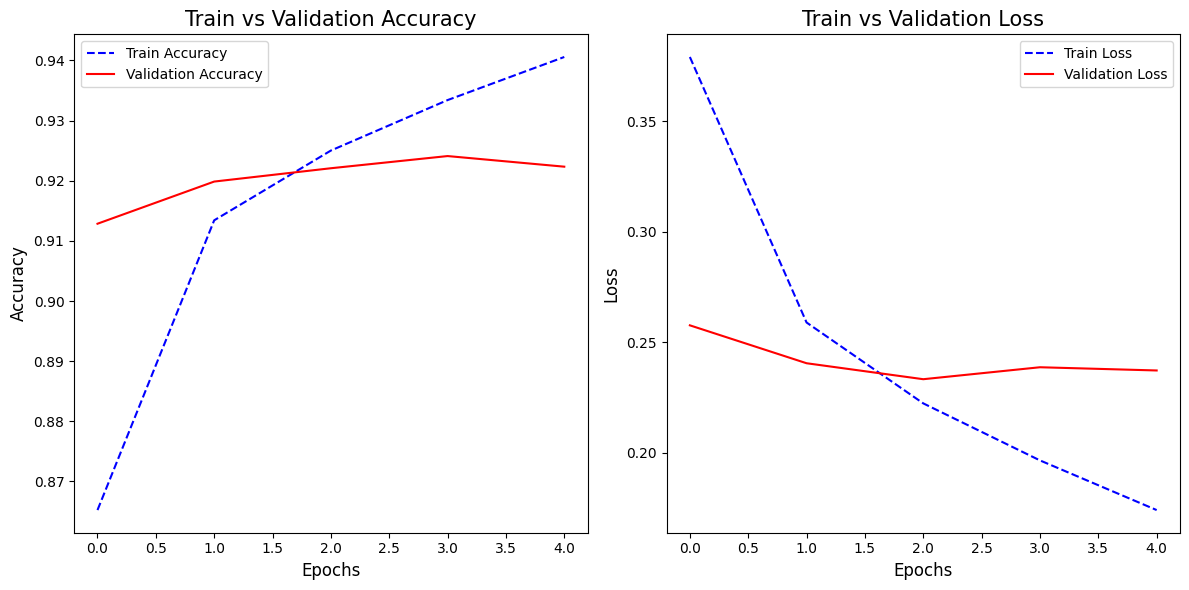

In [ ]:
plot_history(history1)

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, Dense
# Construire le modèle CNN
model = Sequential()
model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Modifier en fonction du nombre de classes


# Compiler le modèle
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



model.summary()

# Configurer un early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entraîner le modèle
history2 = model.fit(
    X_train_padded,
    y_train,
    epochs=5,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_3               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.7960 - loss: 0.5152 - val_accuracy: 0.9006 - val_loss: 0.2890
Epoch 2/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9002 - loss: 0.2911 - val_accuracy: 0.9071 - val_loss: 0.2686
Epoch 3/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9155 - loss: 0.2473 - val_accuracy: 0.9088 - val_loss: 0.2700
Epoch 4/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.9256 - loss: 0.2158 - val_accuracy: 0.9091 - val_loss: 0.2705
Epoch 5/5
7223/7223 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9351 - loss: 0.1886 - val_accuracy: 0.9097 - val_loss: 0.2834


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, matthews_corrcoef
import numpy as np

# Évaluer le modèle
y_pred_prob = model.predict(X_test_padded)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculer et afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, y_pred))

# Calculer et afficher l'accuracy (précision globale)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculer et afficher la précision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculer et afficher le ROC-AUC
# Pour le ROC-AUC, nous devons encoder les labels en format one-hot
from sklearn.preprocessing import label_binarize

y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc}")

# Calculer et afficher le MCC (Matthews Correlation Coefficient)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc}")


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

    negative       0.86      0.94      0.90     27642
     neutral       0.97      0.83      0.90     14732
    positive       0.93      0.91      0.92     29857

    accuracy                           0.91     72231
   macro avg       0.92      0.90      0.91     72231
weighted avg       0.91      0.91      0.91     72231

[[26093   171  1378]
 [ 1725 12270   737]
 [ 2466   215 27176]]
Accuracy: 0.9073527986598552
Precision: 0.9109723052970075
ROC-AUC: 0.9763699435614076
MCC: 0.8559075368662528


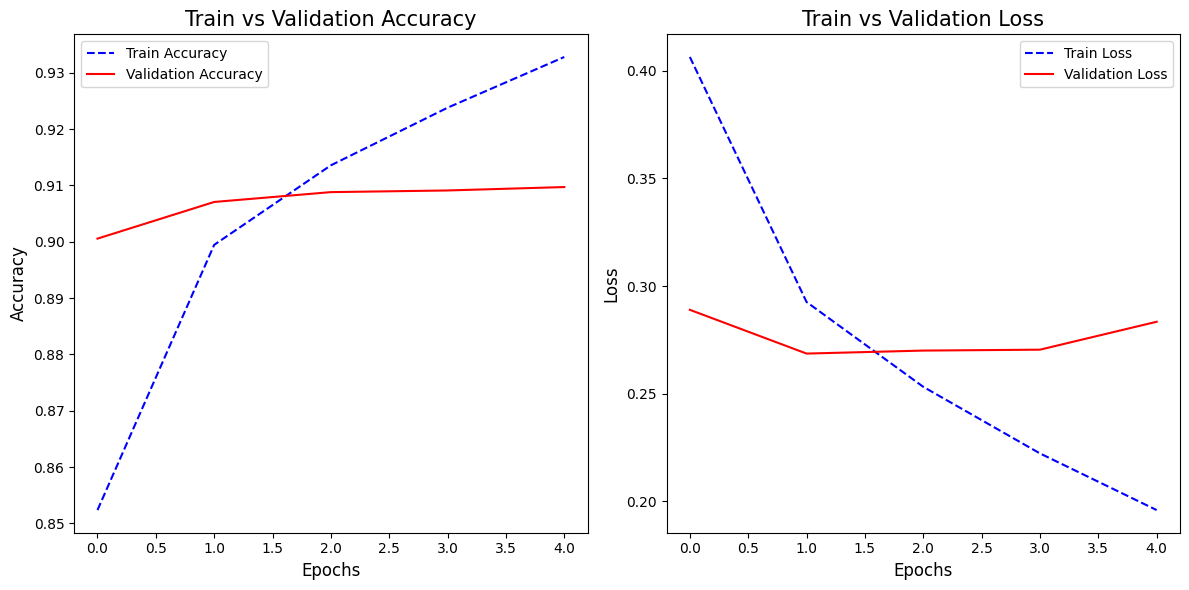

In [ ]:
plot_history(history2)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

# Fonction pour construire les modèles individuels
def build_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # Modifier en fonction du nombre de classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gru_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # Modifier en fonction du nombre de classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # Modifier en fonction du nombre de classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Classe pour utiliser les modèles Keras dans scikit-learn
class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=10, batch_size=32, validation_split=0.2):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.validation_split, callbacks=[early_stopping], verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

# Créer les classifieurs
lstm_classifier = KerasClassifier(build_lstm_model, epochs=20, batch_size=32, validation_split=0.2)
gru_classifier = KerasClassifier(build_gru_model, epochs=20, batch_size=32, validation_split=0.2)
cnn_classifier = KerasClassifier(build_cnn_model, epochs=20, batch_size=32, validation_split=0.2)

# Créer un classifieur d'ensemble utilisant le vote
ensemble_classifier = VotingClassifier(
    estimators=[
        ('lstm', lstm_classifier),
        ('gru', gru_classifier),
        ('cnn', cnn_classifier)
    ],
    voting='soft'
)

# Entraîner le classifieur d'ensemble
ensemble_classifier.fit(X_train_padded, y_train)

# Prédire et évaluer
y_pred = ensemble_classifier.predict(X_test_padded)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

    negative       0.90      0.95      0.92     27642
     neutral       0.98      0.83      0.90     14732
    positive       0.94      0.95      0.94     29857

    accuracy                           0.93     72231
   macro avg       0.94      0.91      0.92     72231
weighted avg       0.93      0.93      0.93     72231

[[26353   128  1161]
 [ 1708 12257   767]
 [ 1337   100 28420]]


In [ ]:
# Évaluer le modèle
y_pred = ensemble_classifier.predict(X_test_padded)

# Calculer et afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, y_pred))

# Calculer et afficher l'accuracy (précision globale)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculer et afficher la précision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculer et afficher le ROC-AUC
# Pour le ROC-AUC, nous devons encoder les labels en format one-hot
y_pred_prob = ensemble_classifier.predict_proba(X_test_padded)
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc}")

# Calculer et afficher le Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc}")


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
              precision    recall  f1-score   support

    negative       0.90      0.95      0.92     27642
     neutral       0.98      0.83      0.90     14732
    positive       0.94      0.95      0.94     29857

    accuracy                           0.93     72231
   macro avg       0.94      0.91      0.92     72231
weighted avg       0.93      0.93      0.93     72231

[[26353   128  1161]
 [ 1708 12257   767]
 [ 1337   100 28420]]
Accuracy: 0.9279949052345946
Precision: 0.9303767409234645
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
ROC-AUC: 0.9850781371728369
MCC: 0.8878323357505595


In [ ]:
ensemble_classifier.score(X_train_padded, y_train)

9029/9029 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
9029/9029 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step
9029/9029 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


0.9458985186210715

In [ ]:
import joblib

In [ ]:
# Enregistrer le voting classifier
joblib.dump(ensemble_classifier, 'voting_model.pkl')

['voting_model.pkl']

In [ ]:

# Enregistrer le tokenizer et le label encoder
import pickle
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pkl', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
import numpy as np
import joblib
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Charger le tokenizer et le label encoder
with open('/content/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('/content/label_encoder.pkl', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Paramètres de séquence
MAX_SEQUENCE_LENGTH = 100

# Charger le stacking model
stacking_classifier = joblib.load('/content/voting_model.pkl')

# Exemple de texte à prédire
text = input("Entrez un texte pour prédire: ")
sequences = tokenizer.texts_to_sequences([text])  # Assurez-vous de passer une liste
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prédiction avec le stacking classifier
y_pred = stacking_classifier.predict(padded)
y_pred_label = label_encoder.inverse_transform(y_pred)
print(f"Prédiction (Stacking): {y_pred_label[0]}")

Entrez un texte pour prédire: i want to eat 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Prédiction (Stacking): positive


In [ ]:
# Paramètres de séquence
MAX_SEQUENCE_LENGTH = 100

In [ ]:
# Charger le stacking model
stacking_classifier = joblib.load('/content/voting_model.pkl')

# Exemple de texte à prédire
text = input("ecrit")
sequences = tokenizer.texts_to_sequences(text)
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prédiction avec le stacking classifier
y_pred = stacking_classifier.predict(padded)
y_pred_label = label_encoder.inverse_transform(y_pred)
print(f"Prédiction: {y_pred_label[0]}")

In [ ]:
# Exemple de texte à prédire
text = input("ecrit")
sequences = tokenizer.texts_to_sequences(text)
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prédiction avec le stacking classifier
y_pred = stacking_classifier.predict(padded)
y_pred_label = label_encoder.inverse_transform(y_pred)
print(f"Prédiction: {y_pred_label[0]}")

In [15]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)


TensorFlow version: 2.16.2
Keras version: 3.4.1


In [16]:
pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import joblib
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Charger le tokenizer et le label encoder
with open('/content/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('/content/label_encoder.pkl', 'rb') as handle:
    label_encoder = pickle.load(handle)

# Paramètres de séquence
MAX_SEQUENCE_LENGTH = 100



# Charger le stacking model
stacking_classifier = joblib.load('/content/voting_model.pkl')

# Exemple de texte à prédire
text = input("Entrez un texte pour prédire: ")
sequences = tokenizer.texts_to_sequences([text])  # Assurez-vous de passer une liste
padded = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Prédiction avec le stacking classifier
y_pred = stacking_classifier.predict(padded)
y_pred_label = label_encoder.inverse_transform(y_pred)
print(f"Prédiction (Stacking): {y_pred_label[0]}")



In [17]:
from sklearn.linear_model import PassiveAggressiveClassifier


In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense, SpatialDropout1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping



# Fonction pour construire les modèles individuels
def build_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # Adapter selon le nombre de classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gru_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(128, return_sequences=True))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # Adapter selon le nombre de classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(SpatialDropout1D(0.2))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(GlobalMaxPooling1D())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))  # Adapter selon le nombre de classes
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Classe pour utiliser les modèles Keras dans scikit-learn
class KerasClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, build_fn, epochs=10, batch_size=32, validation_split=0.2):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.model = None
        self.classes_ = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.classes_ = np.unique(y)  # Définir l'attribut classes_
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, validation_split=self.validation_split, callbacks=[early_stopping], verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

    def predict_proba(self, X):
        return self.model.predict(X)

# Créer les classifieurs
lstm_classifier1 = KerasClassifier(build_lstm_model, epochs=20, batch_size=32, validation_split=0.2)
gru_classifier1 = KerasClassifier(build_gru_model, epochs=20, batch_size=32, validation_split=0.2)
cnn_classifier1 = KerasClassifier(build_cnn_model, epochs=20, batch_size=32, validation_split=0.2)

# Créer le classifieur d'ensemble utilisant le stacking
stacking_classifier = StackingClassifier(
    estimators=[
        ('lstm', lstm_classifier1),
        ('gru', gru_classifier1),
        ('cnn', cnn_classifier1)
    ],
    final_estimator=LogisticRegression(),  # ou un autre classifieur de votre choix
    cv=5
)

# Entraîner le classifieur d'ensemble
stacking_classifier.fit(X_train_padded, y_train)

# Prédire et évaluer
y_pred = stacking_classifier.predict(X_test_padded)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1806/1806 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
1806/1806 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
              precision    recall  f1-score   support

    negative       0.90      0.96      0.93     27642
     neutral       0.97      0.85      0.90     14732
    positive       0.94      0.94      0.94     29857

    accuracy                           0.93     72231
   macro avg       0.94      0.92      0.92     72231
weighted avg       0.93      0.93      0.93     72231

[[26439   224   979]
 [ 1580 12455   697]
 [ 1462   199 28196]]


In [26]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_auc_score, matthews_corrcoef

# Évaluer le modèle
y_pred = stacking_classifier.predict(X_test_padded)

# Calculer et afficher le rapport de classification
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Afficher la matrice de confusion
print(confusion_matrix(y_test, y_pred))

# Calculer et afficher l'accuracy (précision globale)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculer et afficher la précision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision}")

# Calculer et afficher le ROC-AUC
# Pour le ROC-AUC, nous devons encoder les labels en format one-hot
y_pred_prob = stacking_classifier.predict_proba(X_test_padded)
y_test_binarized = label_binarize(y_test, classes=np.arange(len(label_encoder.classes_)))
roc_auc = roc_auc_score(y_test_binarized, y_pred_prob, multi_class='ovr')
print(f"ROC-AUC: {roc_auc}")

# Calculer et afficher le Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"MCC: {mcc}")


2258/2258 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
              precision    recall  f1-score   support

    negative       0.90      0.96      0.93     27642
     neutral       0.97      0.85      0.90     14732
    positive       0.94      0.94      0.94     29857

    accuracy                           0.93     72231
   macro avg       0.94      0.92      0.92     72231
weighted avg       0.93      0.93      0.93     72231

[[26439   224   979]
 [ 1580 12455   697]
 [ 1462   199 28196]]
Accuracy: 0.9288255735072198
Precision: 0.930621217810103
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
2258/2258 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
ROC-AUC: 0.9833892155295211
MCC: 0.8891207418964481


In [21]:
from sklearn.metrics import accuracy_score

In [ ]:
y_pred = stacking_classifier.predict(X_test_padded)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred))